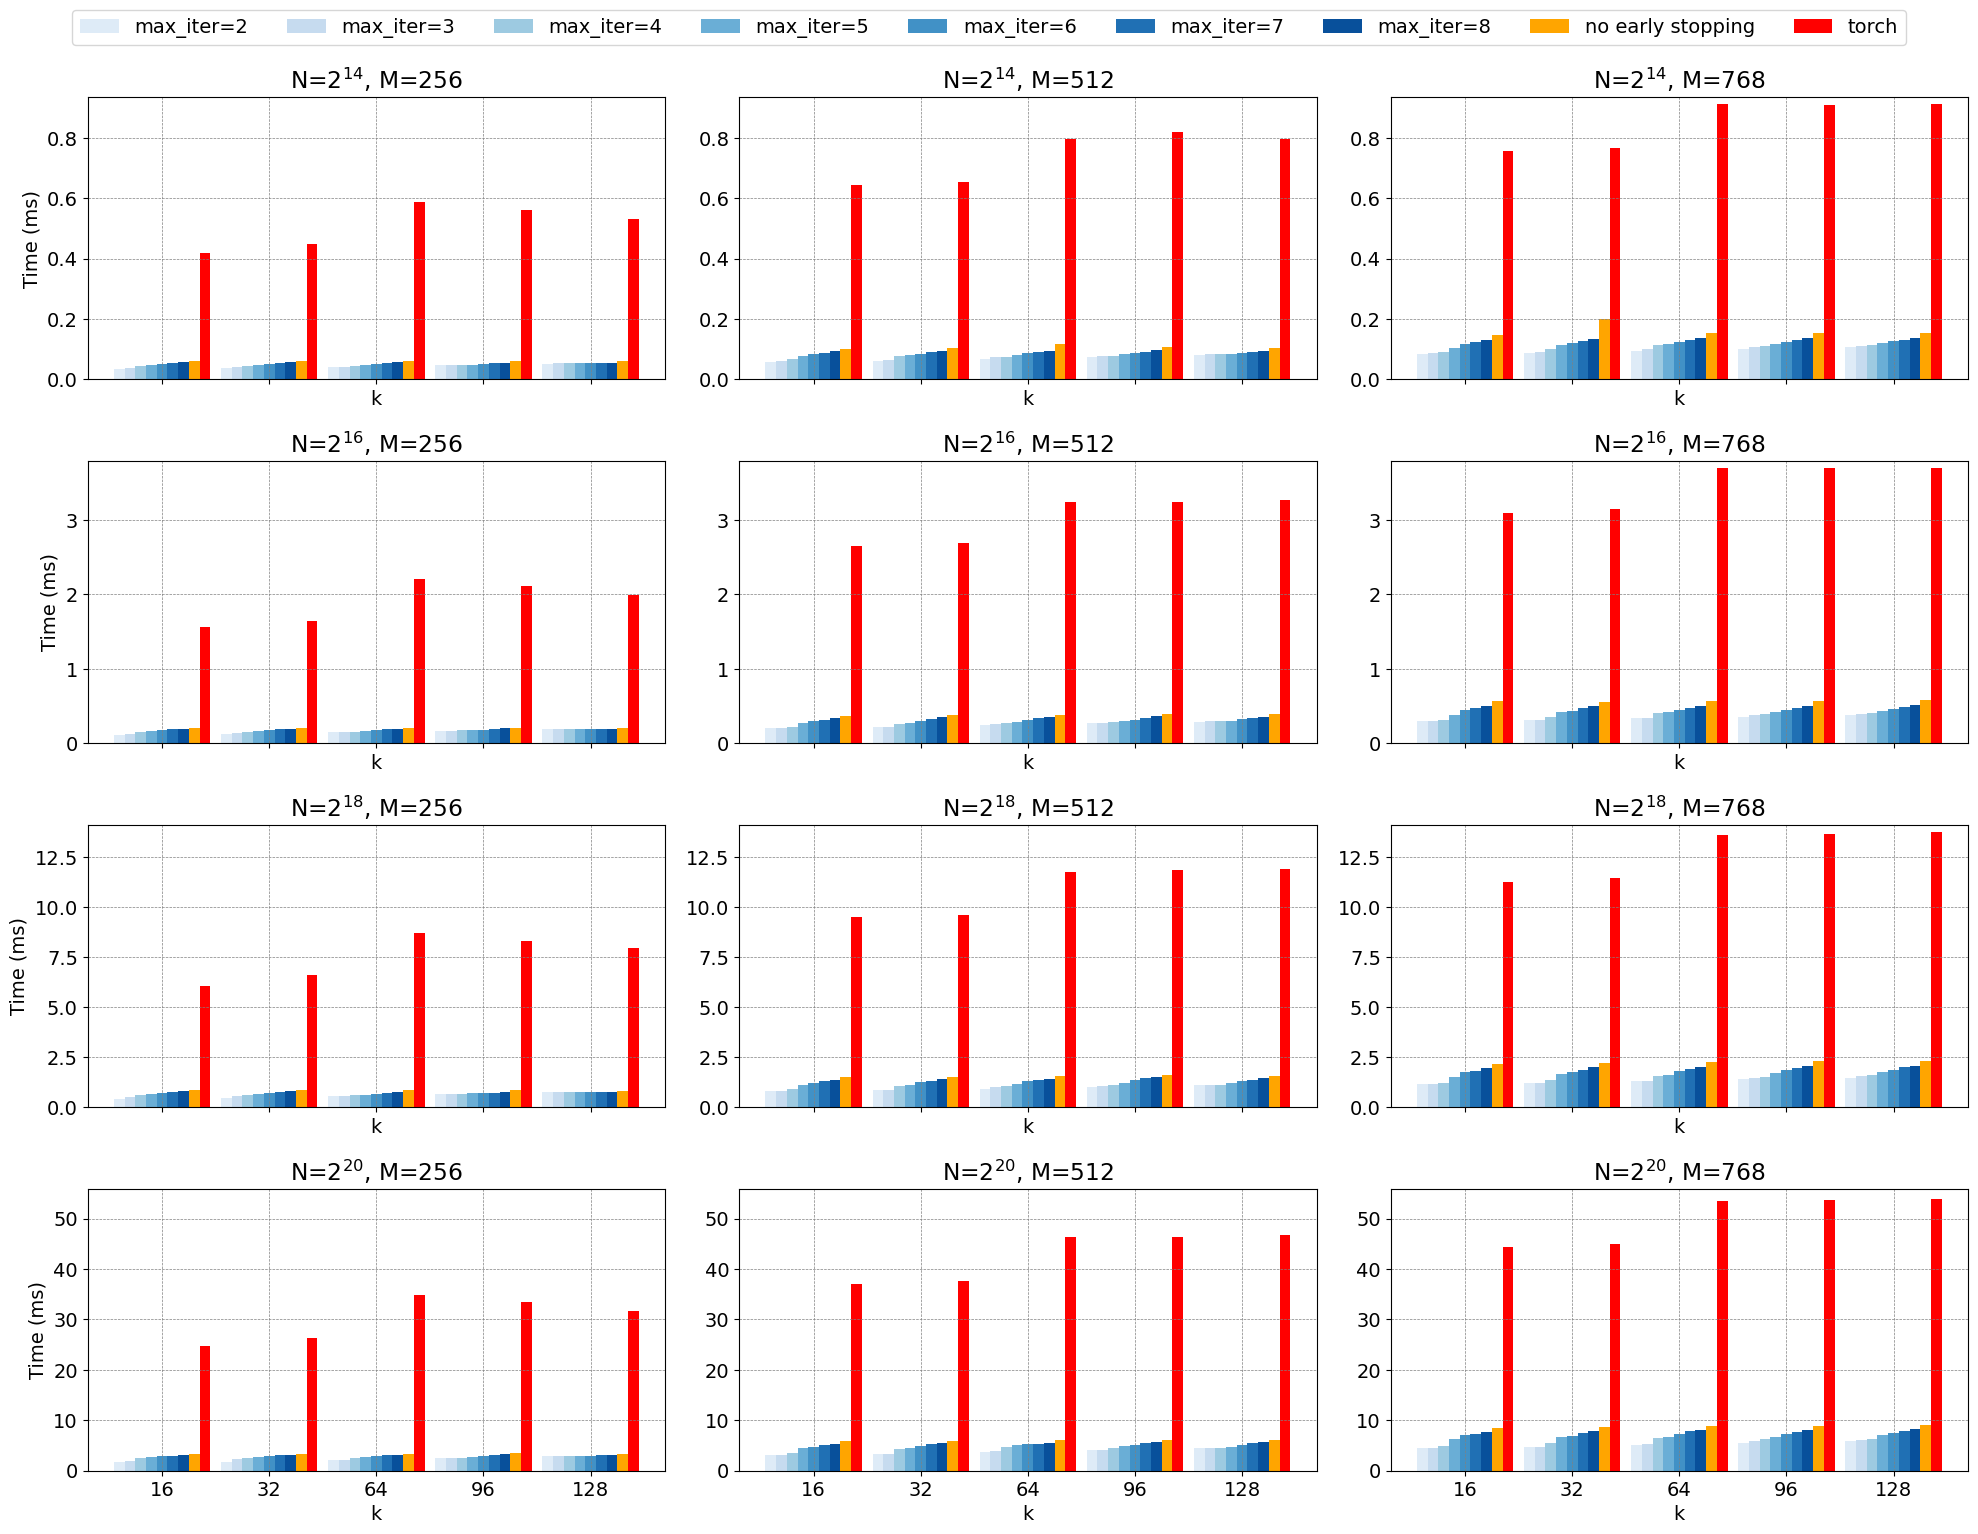

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define a function to manually parse kernel data
def parse_kernel_data(file_path):
    kernel_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            entry = {
                "N": int(parts[0].split('=')[1]),
                "dim_origin": int(parts[1].split('=')[1]),
                "dim_k": int(parts[2].split('=')[1]),
                "max_iter": int(parts[3].split('=')[1]),
                "time": float(parts[4].split('=')[1])
            }
            kernel_data.append(entry)
    return kernel_data

# Define a function to manually parse torch data
def parse_torch_data(file_path):
    torch_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            entry = {
                "N": int(parts[0].split('=')[1]),
                "dim_origin": int(parts[1].split('=')[1]),
                "dim_k": int(parts[2].split('=')[1]),
                "time": float(parts[3].split('=')[1])
            }
            torch_data.append(entry)
    return torch_data

# Load and parse the provided data files
# kernel_data_parsed = parse_kernel_data('output2000.txt')
kernel_data_parsed = parse_kernel_data('output1200.txt')
torch_data_parsed = parse_torch_data('output_torch.txt')

# Convert parsed data into DataFrames for further processing
kernel_data_df = pd.DataFrame(kernel_data_parsed)
torch_data_df = pd.DataFrame(torch_data_parsed)

# Extract no_early_stop data from kernel_data where max_iter == 200
no_early_stop_data_df = kernel_data_df[kernel_data_df['max_iter'] == 200].copy()
kernel_data_df = kernel_data_df[kernel_data_df['max_iter'] != 200]

# Setup unique values and filters
unique_k = sorted(kernel_data_df['dim_k'].unique())
unique_N = sorted(kernel_data_df['N'].unique())
unique_N_labels = [f'$2^{{{int(np.log2(n))}}}$' for n in unique_N]
filtered_dim_origin = [d for d in sorted(kernel_data_df['dim_origin'].unique()) if d != 1024]

# Setup color palette and bar width
custom_palette = sns.color_palette('Blues', len(kernel_data_df['max_iter'].unique()))
bar_width = 0.1

# Set font size for the plots
plt.rcParams.update({'font.size': 14})

# Setup the subplot grid and include no early stop data
fig, axes = plt.subplots(len(unique_N), len(filtered_dim_origin), figsize=(20, 15), sharex=True)

for i, N in enumerate(unique_N):
    max_time = max(
        kernel_data_df[kernel_data_df['N'] == N]['time'].max(),
        torch_data_df[torch_data_df['N'] == N]['time'].max(),
        no_early_stop_data_df[no_early_stop_data_df['N'] == N]['time'].max()
    )
    y_limit = max_time * 0.9  # Add some padding to the max value

    for j, dim_origin in enumerate(filtered_dim_origin):
        ax = axes[i, j]
        kernel_subset = kernel_data_df[(kernel_data_df['N'] == N) & (kernel_data_df['dim_origin'] == dim_origin)]
        torch_subset = torch_data_df[(torch_data_df['N'] == N) & (torch_data_df['dim_origin'] == dim_origin)]
        no_early_stop_subset = no_early_stop_data_df[(no_early_stop_data_df['N'] == N) & (no_early_stop_data_df['dim_origin'] == dim_origin)]
        
        # Enable grid lines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        
        # Plot kernel data
        for idx, max_iter in enumerate(kernel_subset['max_iter'].unique()):
            subset = kernel_subset[kernel_subset['max_iter'] == max_iter]
            ax.bar(
                np.arange(len(unique_k)) + idx * bar_width,
                subset['time'],
                width=bar_width,
                color=custom_palette[idx],
                label=f'max_iter={max_iter}' if i == 0 and j == 0 else ""
            )
        
        # Plot no early stop data (placing it to the left of torch)
        ax.bar(
            np.arange(len(unique_k)) + len(kernel_subset['max_iter'].unique()) * bar_width,
            no_early_stop_subset['time'],
            width=bar_width,
            color='orange',
            label='no early stopping' if i == 0 and j == 0 else ""
        )
        
        # Plot torch data
        ax.bar(
            np.arange(len(unique_k)) + (len(kernel_subset['max_iter'].unique()) + 1) * bar_width,
            torch_subset['time'],
            width=bar_width,
            color='red',
            label='torch' if i == 0 and j == 0 else ""
        )
        
        ax.set_ylim(0, y_limit)
        ax.set_xlabel('k')
        ax.set_xticks(np.arange(len(unique_k)) + bar_width * (len(kernel_subset['max_iter'].unique()) + 1) / 2)
        ax.set_xticklabels(unique_k)
        ax.set_title(f'N={unique_N_labels[i]}, M={dim_origin}')

# Add y-axis label only to the leftmost plots
for ax in axes[:, 0]:
    ax.set_ylabel('Time (ms)')

# Place the legend above the subplots without the "Legend" title
lgd = fig.legend(bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=len(custom_palette) + 2)
plt.tight_layout()

# Save the figure as a PDF with larger font sizes and visible legend
output_path_with_no_early_stop = 'kernel_vs_torch_with_no_early_stop_new.pdf'

plt.savefig(output_path_with_no_early_stop, bbox_extra_artists=(lgd, ), bbox_inches='tight')


In [2]:
import pandas as pd

# 假设你已经解析并加载了数据：kernel_data_df, torch_data_df



# 过滤掉 dim_origin=1024 的数据
kernel_data_df_filtered = kernel_data_df[kernel_data_df['dim_origin'] != 1024]
torch_data_df_filtered = torch_data_df[torch_data_df['dim_origin'] != 1024]
no_early_stop_data_df_filtered = no_early_stop_data_df[no_early_stop_data_df['dim_origin'] != 1024]

# 创建字典来保存每个max_iter的speed up结果
kernel_speed_up_results = {max_iter: [] for max_iter in range(2, 9)}
no_early_stop_speed_up_results = []

# 计算每种max_iter和no early stop相对于torch的speed up
for _, torch_row in torch_data_df_filtered.iterrows():
    N = torch_row['N']
    dim_origin = torch_row['dim_origin']
    dim_k = torch_row['dim_k']
    torch_time = torch_row['time']
    
    # Kernel speed up (for each max_iter)
    kernel_subset = kernel_data_df_filtered[(kernel_data_df_filtered['N'] == N) & 
                                            (kernel_data_df_filtered['dim_origin'] == dim_origin) &
                                            (kernel_data_df_filtered['dim_k'] == dim_k)]
    
    for _, kernel_row in kernel_subset.iterrows():
        max_iter = kernel_row['max_iter']
        if max_iter in kernel_speed_up_results:
            kernel_time = kernel_row['time']
            speed_up = torch_time / kernel_time
            kernel_speed_up_results[max_iter].append(speed_up)
    
    # No early stop speed up
    no_early_stop_row = no_early_stop_data_df_filtered[(no_early_stop_data_df_filtered['N'] == N) & 
                                                       (no_early_stop_data_df_filtered['dim_origin'] == dim_origin) &
                                                       (no_early_stop_data_df_filtered['dim_k'] == dim_k)]
    
    if not no_early_stop_row.empty:
        no_early_stop_time = no_early_stop_row['time'].values[0]
        speed_up = torch_time / no_early_stop_time
        no_early_stop_speed_up_results.append(speed_up)

# 分别计算每个max_iter和no early stop的算术平均值
average_speed_up = {max_iter: sum(speeds) / len(speeds) for max_iter, speeds in kernel_speed_up_results.items()}
average_no_early_stop_speed_up = sum(no_early_stop_speed_up_results) / len(no_early_stop_speed_up_results)

# 输出算术平均值
for max_iter, avg_speed_up in average_speed_up.items():
    print(f'算术平均speed up (kernel_max_iter={max_iter}, 不包括dim_origin=1024): {avg_speed_up:.4f}')
print(f'算术平均speed up (no_early_stop, 不包括dim_origin=1024): {average_no_early_stop_speed_up:.4f}')


算术平均speed up (kernel_max_iter=2, 不包括dim_origin=1024): 11.4857
算术平均speed up (kernel_max_iter=3, 不包括dim_origin=1024): 11.0396
算术平均speed up (kernel_max_iter=4, 不包括dim_origin=1024): 10.2030
算术平均speed up (kernel_max_iter=5, 不包括dim_origin=1024): 9.3740
算术平均speed up (kernel_max_iter=6, 不包括dim_origin=1024): 8.7836
算术平均speed up (kernel_max_iter=7, 不包括dim_origin=1024): 8.3350
算术平均speed up (kernel_max_iter=8, 不包括dim_origin=1024): 7.9928
算术平均speed up (no_early_stop, 不包括dim_origin=1024): 7.2890


In [3]:
import pandas as pd

# 假设你已经解析并加载了数据：kernel_data_df, torch_data_df, no_early_stop_data_df

# 定义需要计算的 dim_origin 值
dim_origin_values = [256, 512, 768]

# 创建嵌套字典来保存每个 max_iter 和 dim_origin 组合的 speed up 结果
kernel_speed_up_results = {dim_origin: {max_iter: [] for max_iter in range(2, 9)} for dim_origin in dim_origin_values}
no_early_stop_speed_up_results = {dim_origin: [] for dim_origin in dim_origin_values}

# 计算每个 max_iter 和 no early stop 相对于 torch 的 speed up，分 dim_origin 计算
for _, torch_row in torch_data_df.iterrows():
    N = torch_row['N']
    dim_origin = torch_row['dim_origin']
    dim_k = torch_row['dim_k']
    torch_time = torch_row['time']
    
    # 只计算指定 dim_origin 的数据
    if dim_origin not in dim_origin_values:
        continue
    
    # Kernel speed up (for each max_iter)
    kernel_subset = kernel_data_df[(kernel_data_df['N'] == N) & 
                                   (kernel_data_df['dim_origin'] == dim_origin) &
                                   (kernel_data_df['dim_k'] == dim_k)]
    
    for _, kernel_row in kernel_subset.iterrows():
        max_iter = kernel_row['max_iter']
        if max_iter in kernel_speed_up_results[dim_origin]:
            kernel_time = kernel_row['time']
            speed_up = torch_time / kernel_time
            kernel_speed_up_results[dim_origin][max_iter].append(speed_up)
    
    # No early stop speed up
    no_early_stop_row = no_early_stop_data_df[(no_early_stop_data_df['N'] == N) & 
                                              (no_early_stop_data_df['dim_origin'] == dim_origin) &
                                              (no_early_stop_data_df['dim_k'] == dim_k)]
    
    if not no_early_stop_row.empty:
        no_early_stop_time = no_early_stop_row['time'].values[0]
        speed_up = torch_time / no_early_stop_time
        no_early_stop_speed_up_results[dim_origin].append(speed_up)

# 分别计算每个 dim_origin 的 max_iter 和 no early stop 的算术平均值
average_speed_up = {dim_origin: {max_iter: (sum(speeds) / len(speeds)) if speeds else 0 
                                 for max_iter, speeds in kernel_speed_up_results[dim_origin].items()} 
                    for dim_origin in dim_origin_values}

average_no_early_stop_speed_up = {dim_origin: (sum(speeds) / len(speeds)) if speeds else 0 
                                  for dim_origin, speeds in no_early_stop_speed_up_results.items()}

# 输出算术平均值
print("Kernel Speed Up Results:")
for dim_origin, avg_speed_up_by_iter in average_speed_up.items():
    for max_iter, avg_speed_up in avg_speed_up_by_iter.items():
        print(f'算术平均speed up (kernel_max_iter={max_iter}, dim_origin={dim_origin}): {avg_speed_up:.4f}')

print("\nNo Early Stop Speed Up Results:")
for dim_origin, avg_speed_up in average_no_early_stop_speed_up.items():
    print(f'算术平均speed up (no_early_stop, dim_origin={dim_origin}): {avg_speed_up:.4f}')


Kernel Speed Up Results:
算术平均speed up (kernel_max_iter=2, dim_origin=256): 13.0727
算术平均speed up (kernel_max_iter=3, dim_origin=256): 12.3168
算术平均speed up (kernel_max_iter=4, dim_origin=256): 11.4629
算术平均speed up (kernel_max_iter=5, dim_origin=256): 10.8640
算术平均speed up (kernel_max_iter=6, dim_origin=256): 10.3226
算术平均speed up (kernel_max_iter=7, dim_origin=256): 9.8817
算术平均speed up (kernel_max_iter=8, dim_origin=256): 9.5465
算术平均speed up (kernel_max_iter=2, dim_origin=512): 11.6561
算术平均speed up (kernel_max_iter=3, dim_origin=512): 11.3661
算术平均speed up (kernel_max_iter=4, dim_origin=512): 10.4268
算术平均speed up (kernel_max_iter=5, dim_origin=512): 9.5082
算术平均speed up (kernel_max_iter=6, dim_origin=512): 8.8700
算术平均speed up (kernel_max_iter=7, dim_origin=512): 8.3449
算术平均speed up (kernel_max_iter=8, dim_origin=512): 7.9759
算术平均speed up (kernel_max_iter=2, dim_origin=768): 9.7285
算术平均speed up (kernel_max_iter=3, dim_origin=768): 9.4358
算术平均speed up (kernel_max_iter=4, dim_origin=768): 8.719

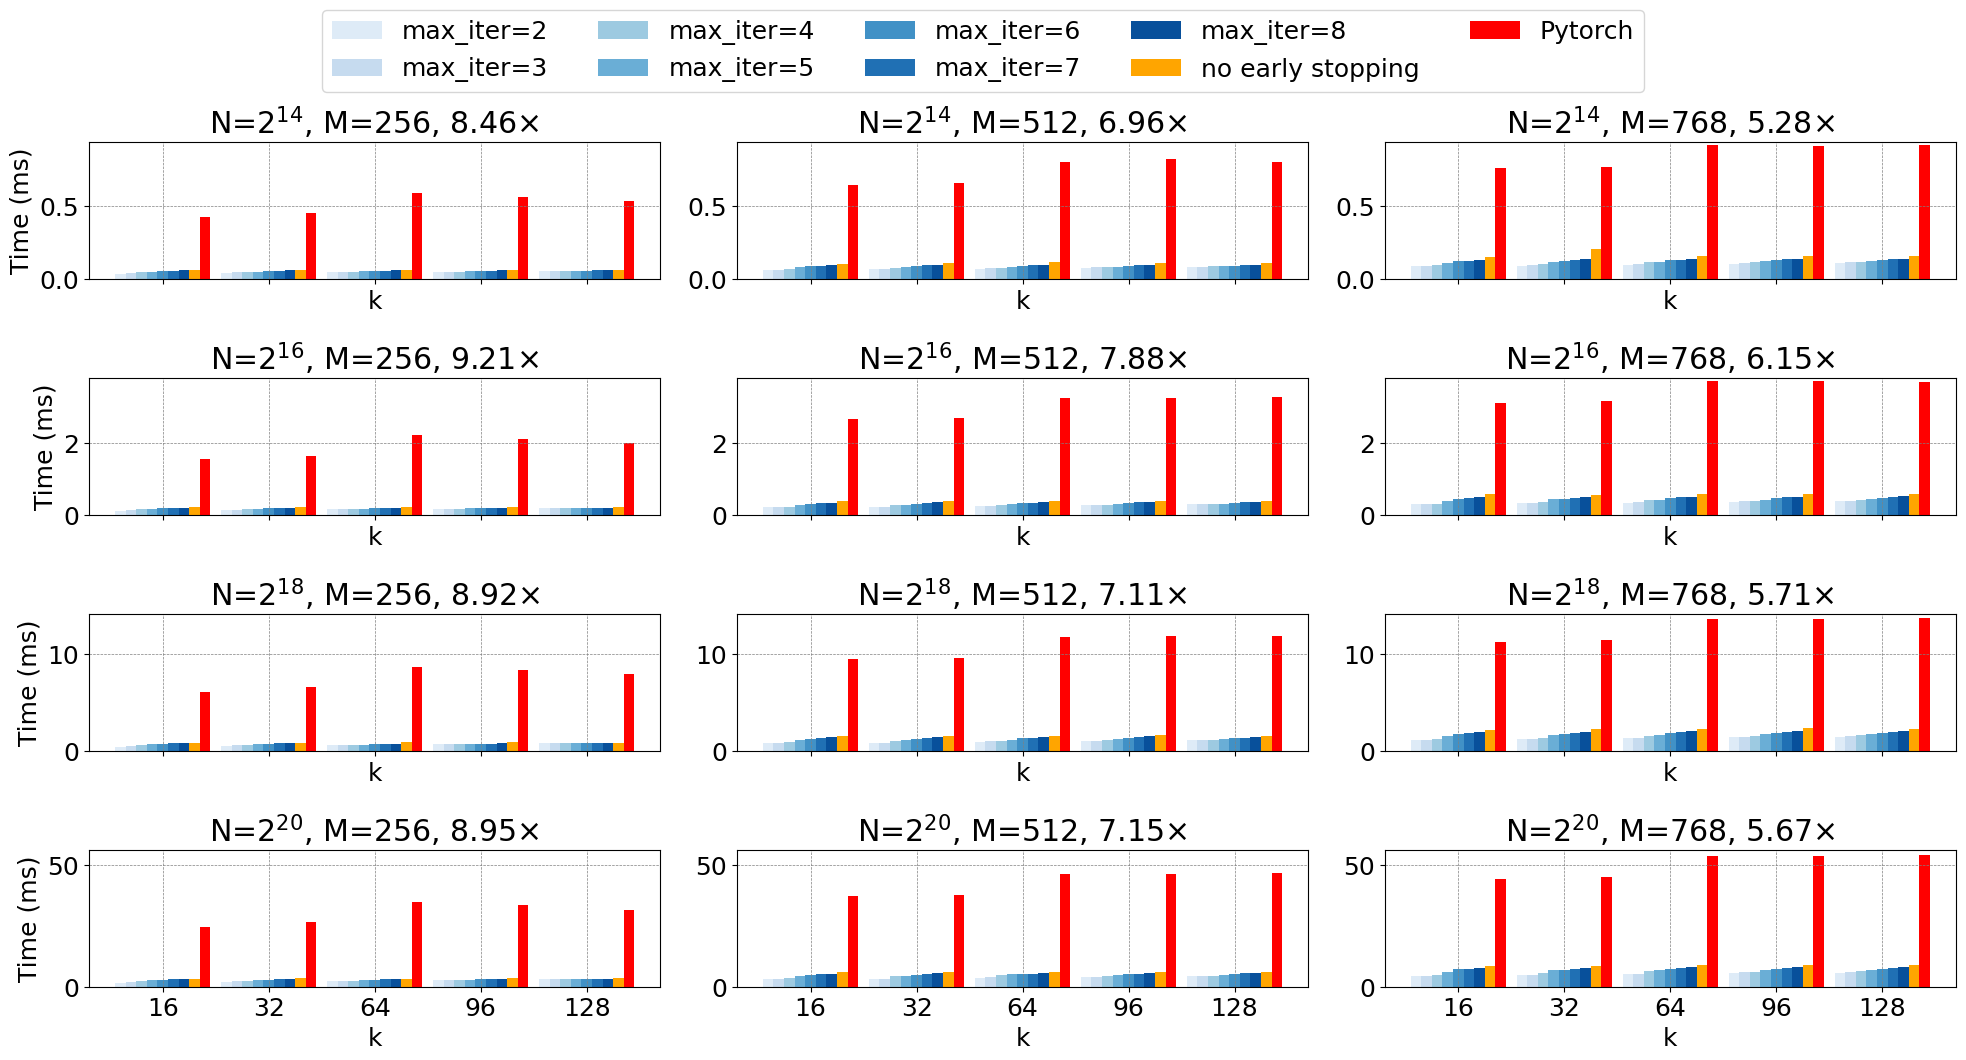

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Define a function to manually parse kernel data
def parse_kernel_data(file_path):
    kernel_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            entry = {
                "N": int(parts[0].split('=')[1]),
                "dim_origin": int(parts[1].split('=')[1]),
                "dim_k": int(parts[2].split('=')[1]),
                "max_iter": int(parts[3].split('=')[1]),
                "time": float(parts[4].split('=')[1])
            }
            kernel_data.append(entry)
    return kernel_data

# Define a function to manually parse torch data
def parse_torch_data(file_path):
    torch_data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(', ')
            entry = {
                "N": int(parts[0].split('=')[1]),
                "dim_origin": int(parts[1].split('=')[1]),
                "dim_k": int(parts[2].split('=')[1]),
                "time": float(parts[3].split('=')[1])
            }
            torch_data.append(entry)
    return torch_data

# Load and parse the provided data files
kernel_data_parsed = parse_kernel_data('output1200.txt')
torch_data_parsed = parse_torch_data('output_torch.txt')

# Convert parsed data into DataFrames for further processing
kernel_data_df = pd.DataFrame(kernel_data_parsed)
torch_data_df = pd.DataFrame(torch_data_parsed)

# Extract no_early_stop data (max_iter == 200) from kernel_data_df
no_early_stop_data_df = kernel_data_df[kernel_data_df['max_iter'] == 200].copy()
kernel_data_df = kernel_data_df[kernel_data_df['max_iter'] != 200].copy()

# Filter data to include only N=2^14, 2^16, 2^18, 2^20
target_N_values = [2**14, 2**16, 2**18, 2**20]
kernel_data_df = kernel_data_df[kernel_data_df['N'].isin(target_N_values)]
torch_data_df = torch_data_df[torch_data_df['N'].isin(target_N_values)]
no_early_stop_data_df = no_early_stop_data_df[no_early_stop_data_df['N'].isin(target_N_values)]

# Setup unique values and filters
unique_k = sorted(kernel_data_df['dim_k'].unique())
unique_N = sorted(kernel_data_df['N'].unique())
unique_N_labels = [f'$2^{{{int(np.log2(n))}}}$' for n in unique_N]
filtered_dim_origin = [d for d in sorted(kernel_data_df['dim_origin'].unique()) if d != 1024]

# Setup color palette and bar width
custom_palette = sns.color_palette('Blues', len(kernel_data_df['max_iter'].unique()))
bar_width = 0.1

# Set font size for the plots
plt.rcParams.update({'font.size': 18})

# Setup the subplot grid and include no early stop data
fig, axes = plt.subplots(len(unique_N), len(filtered_dim_origin), figsize=(20, 10), sharex=True)

for i, N in enumerate(unique_N):
    max_time = max(
        kernel_data_df[kernel_data_df['N'] == N]['time'].max(),
        torch_data_df[torch_data_df['N'] == N]['time'].max(),
        no_early_stop_data_df[no_early_stop_data_df['N'] == N]['time'].max()
    )
    y_limit = max_time * 0.9  # Add some padding to the max value

    for j, dim_origin in enumerate(filtered_dim_origin):
        ax = axes[i, j]
        kernel_subset = kernel_data_df[(kernel_data_df['N'] == N) & (kernel_data_df['dim_origin'] == dim_origin)]
        torch_subset = torch_data_df[(torch_data_df['N'] == N) & (torch_data_df['dim_origin'] == dim_origin)]
        no_early_stop_subset = no_early_stop_data_df[(no_early_stop_data_df['N'] == N) & (no_early_stop_data_df['dim_origin'] == dim_origin)]
        
        # Compute speedup for no early stopping
        if not no_early_stop_subset.empty and not kernel_subset.empty:
            avg_speedup = torch_subset['time'].mean() / no_early_stop_subset['time'].mean()
        else:
            avg_speedup = 1.0
        
        # Enable grid lines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        
        # Plot kernel data
        for idx, max_iter in enumerate(kernel_subset['max_iter'].unique()):
            subset = kernel_subset[kernel_subset['max_iter'] == max_iter]
            ax.bar(
                np.arange(len(unique_k)) + idx * bar_width,
                subset['time'],
                width=bar_width,
                color=custom_palette[idx],
                label=f'max_iter={max_iter}' if i == 0 and j == 0 else ""
            )
        
        # Plot no early stop data (placing it to the left of torch)
        ax.bar(
            np.arange(len(unique_k)) + len(kernel_subset['max_iter'].unique()) * bar_width,
            no_early_stop_subset['time'],
            width=bar_width,
            color='orange',
            label='no early stopping' if i == 0 and j == 0 else ""
        )
        
        # Plot torch data
        ax.bar(
            np.arange(len(unique_k)) + (len(kernel_subset['max_iter'].unique()) + 1) * bar_width,
            torch_subset['time'],
            width=bar_width,
            color='red',
            label='Pytorch' if i == 0 and j == 0 else ""
        )
        
        ax.set_ylim(0, y_limit)
        ax.set_xlabel('k')
        ax.set_xticks(np.arange(len(unique_k)) + bar_width * (len(kernel_subset['max_iter'].unique()) + 1) / 2)
        ax.set_xticklabels(unique_k)
        ax.set_title(f'N={unique_N_labels[i]}, M={dim_origin}, {avg_speedup:.2f}×')

# Add y-axis label only to the leftmost plots
for ax in axes[:, 0]:
    ax.set_ylabel('Time (ms)')

# Place the legend above the subplots without the "Legend" title
lgd = fig.legend(bbox_to_anchor=(0.5, 1.08), loc='upper center', ncol=5)
plt.tight_layout()

# Save the figure as a PDF with larger font sizes and visible legend
output_path_with_no_early_stop = 'kernel_vs_torch_with_no_early_stop_new.pdf'

plt.savefig(output_path_with_no_early_stop, bbox_extra_artists=(lgd, ), bbox_inches='tight')
